---
## Step 0: Load The Data

In [1]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import albumentations as albu
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# Model configuration
batch_size = 128
loss_function = 'mean_squared_error'
optimizer = Adam()
validation_split = 0.2
verbosity = 1

import cv2
import numpy as np
import pandas as pd
from keras.preprocessing import image


# import thumbnail image (model1 input)
img_list = pd.read_csv('YT_output.csv')    #, nrows=1182
num_img = img_list.shape[0]

data_train = []
#data_train = np.empty(num_img, dtype=int)

print(num_img)
for i in range(0, num_img):
    file_name = img_list['id'][i]
    # img = image.load_img("download_image\%s.jpg" % file_name, target_size=(360, 480))
    try:
        if '=' in file_name:
            file_name = file_name.replace('=','')
            print(file_name)
    except:
        pass
    img = cv2.imread('download_image\%s.jpg' % file_name)
    img = img[80:280, 0:480]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    data_train.append(img)
    #data_train[i] = cv2.imread('download_image\%s.jpg' % file_name)

print("img:",img.shape)
print("img:",type(img))
# Determine shape of the data
input_shape = img.shape
input_train = np.array(data_train)
target_train = np.array(pd.read_csv('PopularityScore.csv')).astype('float32')

C:\Users\crazy\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\crazy\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\crazy\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\crazy\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


3565
img: (200, 480, 3)
img: <class 'numpy.ndarray'>


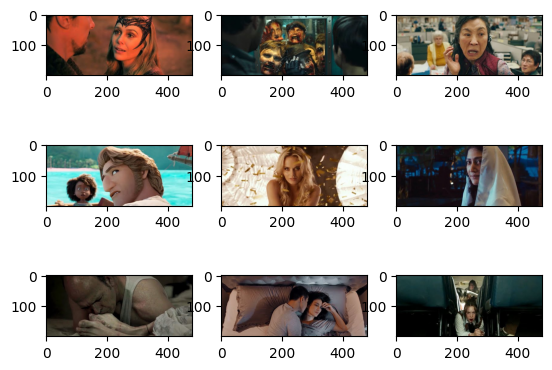

(3565, 200, 480, 3)


In [2]:
# plot first few images
for i in range(9):
 # define subplot
 plt.subplot(330 + 1 + i)
 # plot raw pixel data
 plt.imshow(input_train[i])
# show the figure
plt.show()
print(input_train.shape)

In [3]:
size = 128
def convert_cifar100_224pix(X):
    from PIL import Image
    import numpy as np
    X = np.reshape(X, (num_img, 200, 480, 3))  # 将图片转换成(m, channel,n_H,n_W)
    # X = X.transpose(0, 2, 3, 1)  # 转换成标准的矩阵(m, n_H,n_W, channel)
    X_resized = np.zeros((num_img,size,size,3))# 创建一个存储修改过图片分辨率的矩阵

    for i in range(0,num_img):
        img = X[i]
        img = Image.fromarray(img)
        img = np.array(img.resize((size,size),Image.LANCZOS))# 修改分辨率，再转为array类
        X_resized[i,:,:,:] = img

    # X_resized /= 255
    return X_resized

In [4]:
import matplotlib.pyplot as plt
import numpy as np

input_train = convert_cifar100_224pix(input_train)
# fig, axarr = plt.subplots(1, 2)
# axarr[0].imshow(input_train[0])
# axarr[1].imshow(input_train[1])

C:\Users\crazy\AppData\Local\Temp\ipykernel_15484\2226014845.py:12: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = np.array(img.resize((size,size),Image.LANCZOS))# 修改分辨率，再转为array类


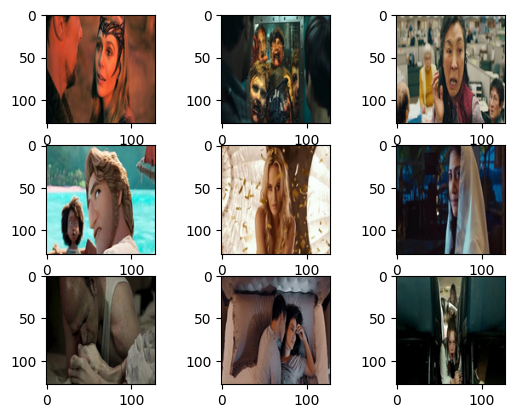

(3565, 128, 128, 3)


In [5]:
# plot first few images
for i in range(9):
 # define subplot
 plt.subplot(330 + 1 + i)
 # plot raw pixel data
 plt.imshow(input_train[i]/255)
# show the figure
plt.show()
print(input_train.shape)

In [6]:
print(input_train[0].shape)

(128, 128, 3)


In [7]:
target_train = target_train.flatten()
print(target_train.shape)

(3565,)


In [8]:
from sklearn.model_selection import train_test_split
input_train = input_train.reshape(-1, size, size, 3).astype('float32')/255
# input_test = input_test.reshape(-1, size, size, 3).astype('float32')/255

# target_train = to_categorical(target_train)

train_data,val_data,train_label,val_label=train_test_split(input_train,target_train,test_size=0.2,random_state=13)

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_agu = ImageDataGenerator(
    # rescale=1./255,
    rotation_range=25,  # Random rotation between 0 and 45
    width_shift_range=0.2,  # % shift
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # vertical_flip=True,
    fill_mode='nearest', cval=125)  # Also try nearest, constant, reflect, wrap

train_agu.fit(train_data)
train_generator = train_agu.flow(train_data, train_label, batch_size=batch_size)

In [10]:
# 定义模型 =======================================================================================
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.applications.densenet.DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow
# model = ResNet50(weights='imagenet')
base_model = EfficientNetB0(
    weights="imagenet", include_top=False,
    input_shape=(size, size, 3))  # 预训练的ResNet50网络，替换掉顶部网络

for layer in base_model.layers[:15]:
    layer.trainable = False  # 冻结预训练网络前15层，最后的卷积神经网络块可训练

top_model = Sequential()  # 自定义顶层网络
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))  # 将预训练网络展平
top_model.add(Dropout(0.5))  # Dropout概率0.5
# top_model.add(Dense(2048, activation='relu'))  # 全连接层，输入像素
# top_model.add(Dropout(0.25))  # Dropout概率0.5
top_model.add(Dense(1024, activation='relu'))  # 全连接层，输入像素
top_model.add(Dropout(0.5))  # Dropout概率0.5
# top_model.add(Dense(512, activation='relu'))  # 全连接层，输入像素
# top_model.add(Dropout(0.5))  # Dropout概率0.5
top_model.add(Dense(1, activation='linear'))  # 输出层，100分类

In [11]:
model = Model(
    inputs=base_model.input,
    outputs=top_model(base_model.output))  # 新网络=预训练网络+自定义网络

# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['mean_squared_error'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 128, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [12]:
# Fit data to model
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)
# history = model.fit(input_train, target_train,
#                     batch_size=batch_size,
#                     callbacks=[rlrop, early_stop],
#                     epochs=100,
#                     verbose=verbosity,
#                     validation_split=validation_split)

history = model.fit(train_generator,
                    batch_size=batch_size,
                    callbacks=[rlrop, early_stop],
                    epochs=200,
                    verbose=verbosity,
                    validation_data=(val_data,val_label))

Epoch 1/200
23/23 [==============================] - 17s 388ms/step - loss: 93.5836 - mean_squared_error: 93.5836 - val_loss: 153.7115 - val_mean_squared_error: 153.7115
Epoch 2/200
23/23 [==============================] - 7s 315ms/step - loss: 25.2141 - mean_squared_error: 25.2141 - val_loss: 160.0151 - val_mean_squared_error: 160.0151
Epoch 3/200
23/23 [==============================] - 7s 314ms/step - loss: 16.4756 - mean_squared_error: 16.4756 - val_loss: 210.9549 - val_mean_squared_error: 210.9549
Epoch 4/200
23/23 [==============================] - 7s 311ms/step - loss: 12.9159 - mean_squared_error: 12.9159 - val_loss: 103.9632 - val_mean_squared_error: 103.9632
Epoch 5/200
23/23 [==============================] - 8s 318ms/step - loss: 10.7823 - mean_squared_error: 10.7823 - val_loss: 84.7317 - val_mean_squared_error: 84.7317
Epoch 6/200
23/23 [==============================] - 7s 316ms/step - loss: 9.8315 - mean_squared_error: 9.8315 - val_loss: 82.3964 - val_mean_squared_error:

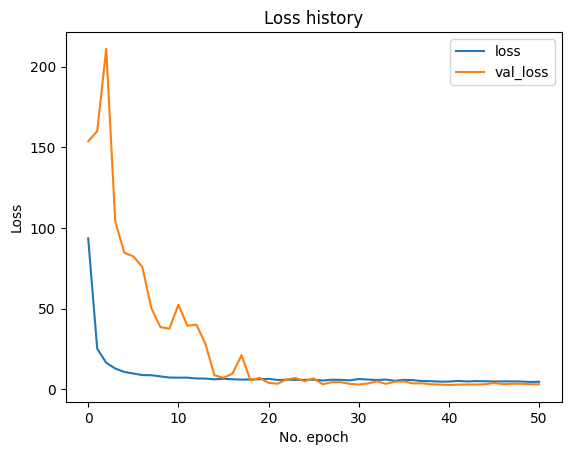

In [19]:
# Visualize history
# Plot history: Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('Loss history')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

# # Plot history: Accuracy
# plt.plot(history.history['val_accuracy'])
# plt.title('Validation accuracy history')
# plt.ylabel('Accuracy value (%)')
# plt.xlabel('No. epoch')
# plt.show()

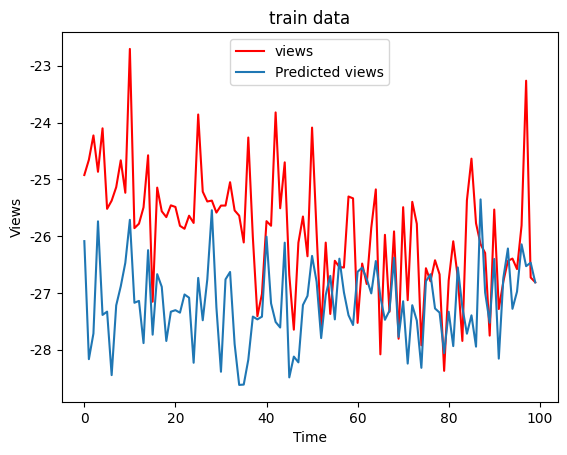

In [20]:
import matplotlib.pyplot as plt
pred = model.predict(input_train) #訓練好model使用predict預測看看在訓練的model跑的回歸線

plt.plot(target_train[:100],'red' ,label='views')#畫出回歸線
plt.plot(pred[:100],label='Predicted views')
#plt.plot(x_train, y_train, 'o') #畫出原本的點
plt.title('train data')
plt.xlabel('Time')
plt.ylabel('Views')
plt.legend()
plt.show()

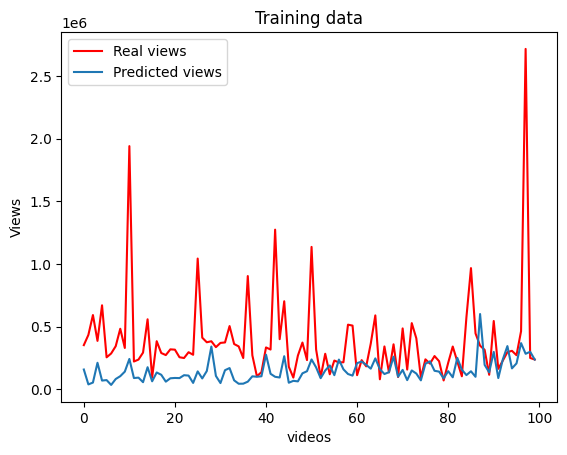

In [21]:
import time
struct_time = time.strptime("2022-12-08 22:00:00", "%Y-%m-%d %H:%M:%S")
time_stop = int(time.mktime(struct_time))

import matplotlib.pyplot as plt
pred = model.predict([input_train]) #訓練好model使用predict預測看看在訓練的model跑的回歸線
for i in range(0, len(target_train)):
    time_ord = time.strptime(img_list['publishedAt'][i], "%Y-%m-%d %H:%M:%S")
    time_now = int(time.mktime(time_ord))
    timetonow = time_stop - time_now
    target_train[i] = (2**(target_train[i]-1))*timetonow*img_list['subscriberCount'][i]
    pred[i] = (2**(pred[i]-1))*timetonow*img_list['subscriberCount'][i]

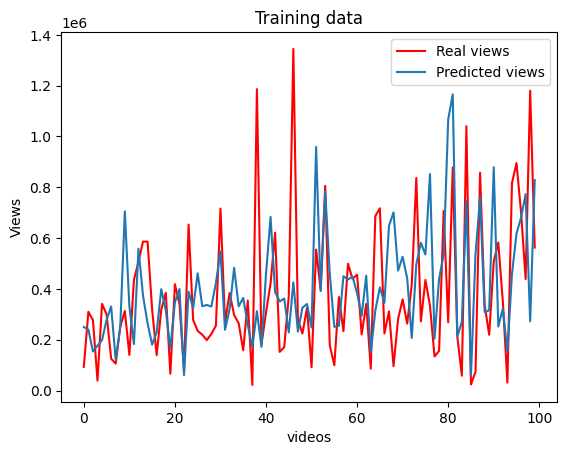

In [23]:
plt.plot(target_train[200:300],'red' ,label='Real views')#畫出回歸線
plt.plot(pred[200:300],label='Predicted views')
#plt.plot(x_train, y_train, 'o') #畫出原本的點
plt.title('Training data')
plt.xlabel('videos')
plt.ylabel('Views')
plt.legend()
plt.show()

In [15]:
# save model
model.save('BO-6.64.h5')

C:\Users\crazy\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [15]:
# Generate generalization metrics
score = model.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.3014376163482666 / Test accuracy: 0.7771999835968018


In [18]:
import tensorflow
loaded_model = tensorflow.keras.models.load_model('MobleNet_128-0.77_300.h5')
for layer in loaded_model.layers:
    if isinstance(layer, tensorflow.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

for index, layer in enumerate(loaded_model.layers):
    print("Layer: {}, Trainable: {}".format(index, layer.trainable))

Layer: 0, Trainable: True
Layer: 1, Trainable: True
Layer: 2, Trainable: False
Layer: 3, Trainable: True
Layer: 4, Trainable: True
Layer: 5, Trainable: False
Layer: 6, Trainable: True
Layer: 7, Trainable: True
Layer: 8, Trainable: False
Layer: 9, Trainable: True
Layer: 10, Trainable: False
Layer: 11, Trainable: True
Layer: 12, Trainable: True
Layer: 13, Trainable: True
Layer: 14, Trainable: False
Layer: 15, Trainable: True
Layer: 16, Trainable: True
Layer: 17, Trainable: False
Layer: 18, Trainable: True
Layer: 19, Trainable: False
Layer: 20, Trainable: True
Layer: 21, Trainable: True
Layer: 22, Trainable: False
Layer: 23, Trainable: True
Layer: 24, Trainable: True
Layer: 25, Trainable: False
Layer: 26, Trainable: True
Layer: 27, Trainable: True
Layer: 28, Trainable: False
Layer: 29, Trainable: True
Layer: 30, Trainable: True
Layer: 31, Trainable: True
Layer: 32, Trainable: False
Layer: 33, Trainable: True
Layer: 34, Trainable: True
Layer: 35, Trainable: False
Layer: 36, Trainable: True

# make a prediction for a new image.

In [20]:
# Recompile after turning to trainable
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-6)
loss_function = categorical_crossentropy
loaded_model.compile(loss=loss_function,
                  optimizer=optimizer,
                  metrics=["accuracy"])

history = loaded_model.fit(train_generator,
                        epochs=100,
                        validation_data=(val_data,val_label))

loaded_model.save('MobleNet_128-0.77_300_re.h5')

Epoch 1/100
313/313 [==============================] - 110s 342ms/step - loss: 0.0798 - accuracy: 0.9748 - val_loss: 1.3315 - val_accuracy: 0.7799
Epoch 2/100
313/313 [==============================] - 109s 347ms/step - loss: 0.0775 - accuracy: 0.9759 - val_loss: 1.3256 - val_accuracy: 0.7814
Epoch 3/100
313/313 [==============================] - 107s 342ms/step - loss: 0.0772 - accuracy: 0.9752 - val_loss: 1.3317 - val_accuracy: 0.7810
Epoch 4/100
313/313 [==============================] - 111s 353ms/step - loss: 0.0768 - accuracy: 0.9762 - val_loss: 1.3277 - val_accuracy: 0.7809
Epoch 5/100
313/313 [==============================] - 111s 353ms/step - loss: 0.0766 - accuracy: 0.9753 - val_loss: 1.3376 - val_accuracy: 0.7811
Epoch 6/100
313/313 [==============================] - 109s 347ms/step - loss: 0.0750 - accuracy: 0.9759 - val_loss: 1.3347 - val_accuracy: 0.7815
Epoch 7/100
313/313 [==============================] - 110s 351ms/step - loss: 0.0718 - accuracy: 0.9772 - val_loss: 1

NameError: name 'model' is not defined

In [21]:
loaded_model.save('MobleNet_128-0.77_300_re.h5')

C:\Users\crazy\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [18]:
# make a prediction for a new image.
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model


# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(32, 32))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 32, 32, 3)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img


# load an image and predict the class
def run_example():
    # load the image
    img = load_image('1.png')
    # load model
    model = load_model('cifa100_64.h5')
    # predict the class
    result = model.predict(img)
    print(result)


run_example()

[[3.88291774e-05 2.51380168e-03 7.45759532e-03 3.97707663e-05
  1.87714431e-05 9.36488868e-05 2.24273444e-05 7.90917984e-05
  8.74663529e-05 1.46431185e-03 9.04617598e-04 3.30107985e-03
  2.72756256e-06 2.55434552e-05 3.27362766e-04 7.58837850e-04
  3.76690537e-06 6.14356521e-09 9.31217102e-04 2.99039792e-04
  2.16570437e-01 1.28869811e-04 7.72903324e-04 1.69365812e-04
  3.80873643e-02 5.45603894e-02 2.30504617e-01 1.05359177e-04
  1.65518541e-02 3.93827520e-02 2.47321750e-05 8.50625220e-04
  3.79179679e-02 1.56174166e-04 7.10527020e-05 2.42008339e-03
  1.58543353e-05 6.76760870e-09 4.49206982e-06 2.16535300e-05
  1.20498976e-02 5.67497278e-04 3.30906332e-05 4.14864144e-06
  5.43170283e-03 2.51196269e-02 3.03979672e-04 4.59571510e-08
  1.03655190e-03 9.37466393e-05 4.87050004e-02 1.10901659e-02
  5.39336718e-12 1.84119779e-06 8.86000780e-05 5.95320854e-03
  2.91685228e-06 2.14950554e-02 1.98584239e-05 1.73020524e-07
  1.71834091e-09 9.58951947e-04 6.06898405e-02 4.80533112e-04
  1.1154

C:\Users\crazy\AppData\Roaming\Python\Python39\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


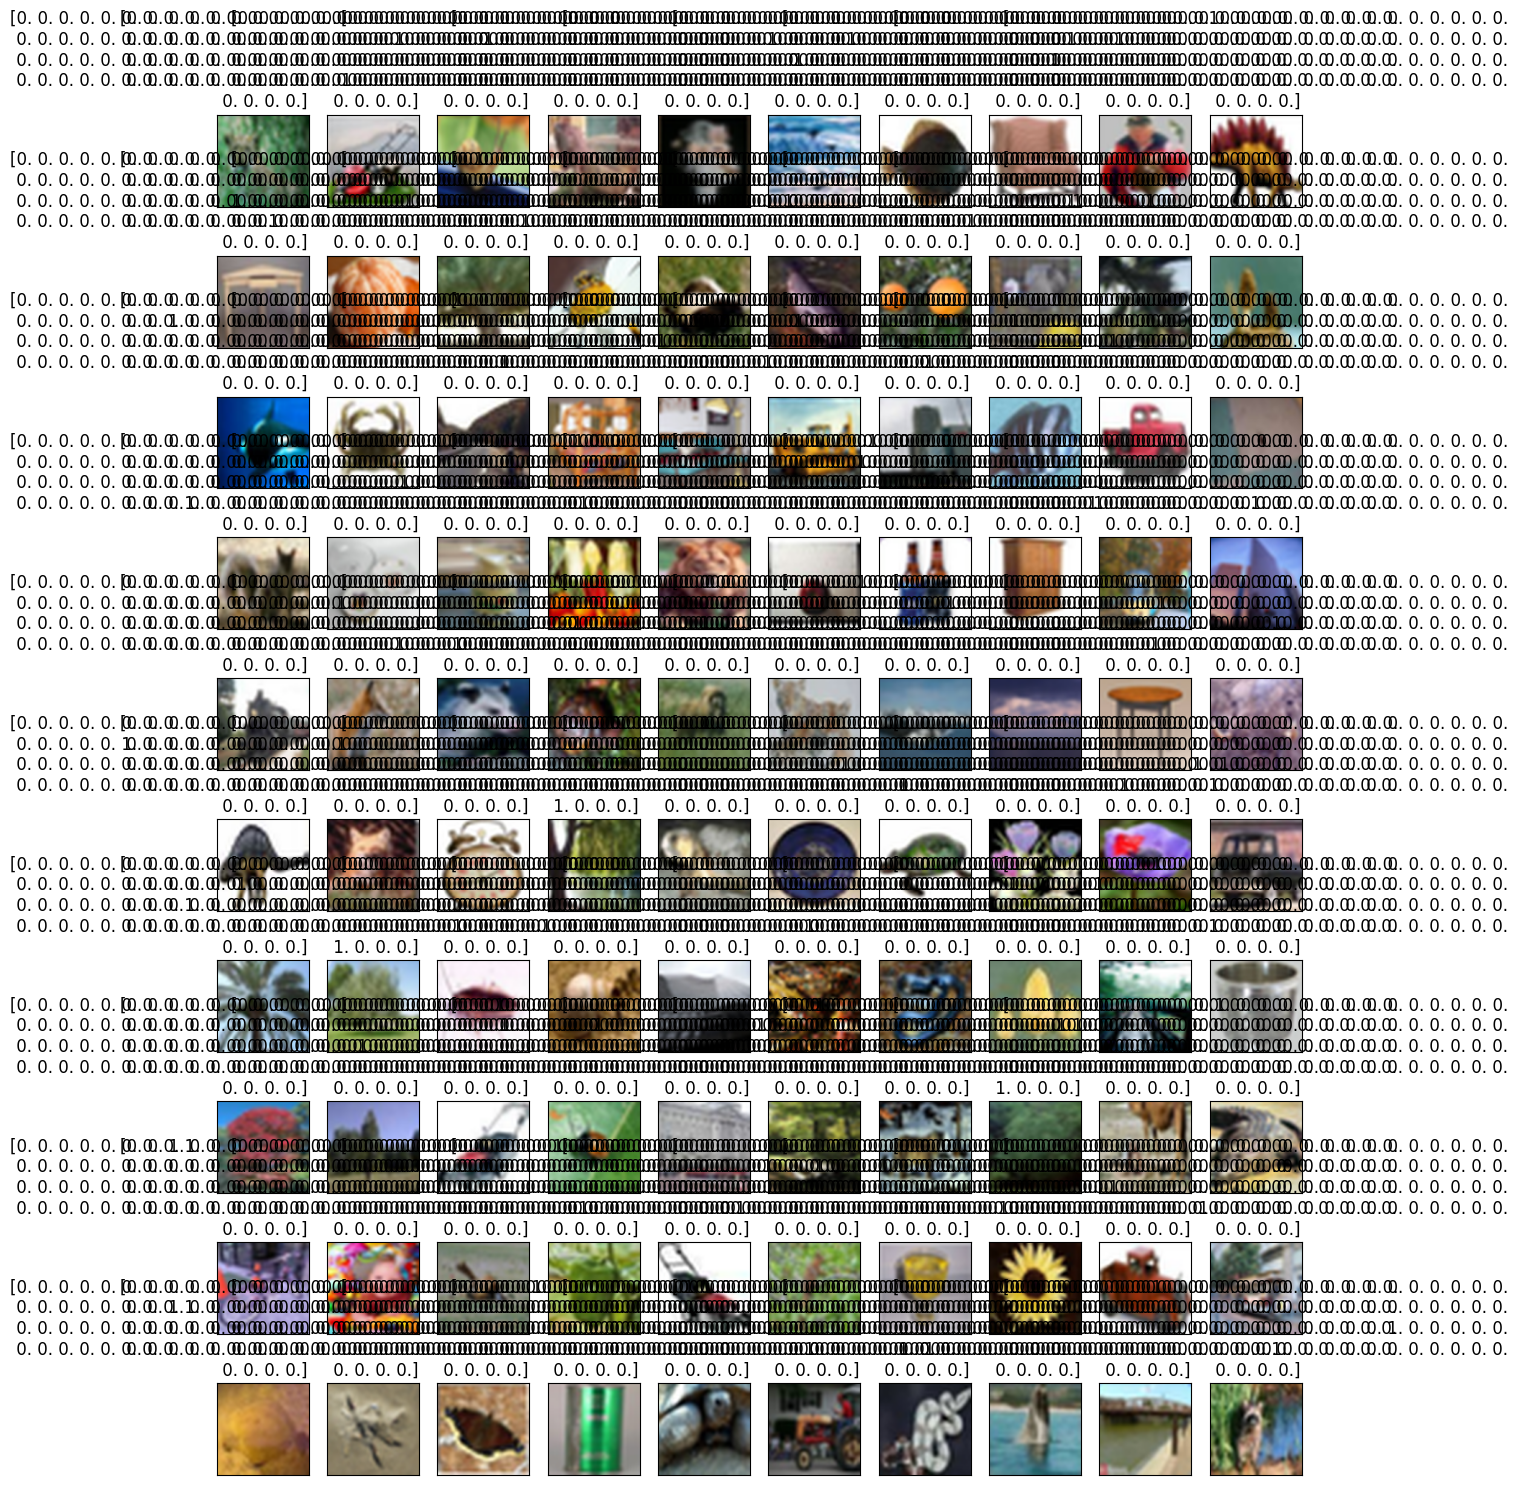

In [19]:
import numpy as np

# Show sample random image 14x18
plt.figure(figsize=(14, 18))
for i in range(100):
    rand_num = np.random.randint(0, 50000)
    cifar_img = plt.subplot(10, 10, i + 1)
    plt.imshow(input_train[rand_num])
    # Erase the value of a tick
    plt.xticks(color="None")
    plt.yticks(color="None")
    # Erase the tick x-axis and y-axis
    plt.tick_params(length=0)
    # Show correct label
    # plt.title(target_train[rand_num])

plt.show()